In [1]:
# Handle different types of transformation
# different nb of pixels
# different nb of level of gray

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
# from sklearn import tree
import os
import random

mpl.rc('image', cmap='gray_r')
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense
from keras.models import load_model

C:\Users\MariO\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Useful methods

In [3]:
def rot90ccw(mat):
    """ Rotate an n by n matrix 90 deg counter clock wise"""
    
    # rotation matrix
    rot = np.array([[0, 1],
               [-1,0]])
    # matrix coordinates
    coord = [i for i in np.ndindex(mat.shape)]
    nbp = mat.shape[0]    
    # initialisations
    coord_rot = []
    mat_rot = np.zeros((mat.shape))    
    # Apply the transformation on each pixel's coordinates
    for ii in range(0,len(coord)):
        # apply the rotation to the coordinate vector
        coord_rot.append(coord[ii]@rot)
        # reverse the row axis
        coord_rot[ii][0] += nbp-1
        # transform back into a tuple
        coord_rot[ii] = tuple(coord_rot[ii])   
        # fill up the rotated matrix
        mat_rot[coord_rot[ii]] = mat[coord[ii]]        
    
    return mat_rot

def rot90cw(mat):
    """ Rotate an n by n matrix 90 deg clock wise"""
    
    # rotation matrix
    rot = np.array([[0, -1],
               [1,0]])    
    # matrix coordinates
    coord = [i for i in np.ndindex(mat.shape)]
    nbp = mat.shape[0]    
    # initialisations
    coord_rot = []
    mat_rot = np.zeros((mat.shape))    
    # Apply the transformation on each pixel's coordinates
    for ii in range(0,len(coord)):
        # apply the rotation to the coordinate vector
        coord_rot.append(coord[ii]@rot)
        # reverse the row axis
        coord_rot[ii][1] += nbp-1
        # transform back into a tuple
        coord_rot[ii] = tuple(coord_rot[ii])   
        # fill up the rotated matrix
        mat_rot[coord_rot[ii]] = mat[coord[ii]]        
    
    return mat_rot

In [4]:
# Transformation matrices
def create_PPstar_translation(nbpix):
    # nb of pixels translated
    nbt = int(np.round(0.25*nbpix))

    # bottom left square block
    bl = np.eye(nbpix-nbt,nbpix-nbt)
    # upper right square block
    ur = np.eye(nbt,nbt)
    # upper left rect block
    ul = np.zeros((nbt,nbpix-nbt))
    # bottom right rect block
    br = np.zeros((nbpix-nbt,nbt))

    # concatenate the blocks to build the transformation matrix
    P = np.concatenate((np.concatenate((ul,ur), axis=1), np.concatenate((bl,br), axis=1)), axis=0)
    Pstar = np.linalg.inv(P)        
    return (P,Pstar)

def translate2left(mat):
    P,Pstar = create_PPstar_translation(mat.shape[0])
    return mat@P
def translate2right(mat):
    P,Pstar = create_PPstar_translation(mat.shape[0])
    return mat@Pstar


In [5]:
# plt.figure(1)
def remove_ticks():
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
    plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off    
    return

def vis_matrices(Mr, Mm, Mst, MstM):
#     print(Mr.shape[0])
    if Mr.shape[0]==1:
        Mr = Mr.reshape(int(np.sqrt(Mr.shape[1])), int(np.sqrt(Mr.shape[1])))
        Mm = Mm.reshape(int(np.sqrt(Mm.shape[1])), int(np.sqrt(Mm.shape[1])))
        Mst = Mst.reshape(int(np.sqrt(Mst.shape[1])), int(np.sqrt(Mst.shape[1])))
        MstM = MstM.reshape(int(np.sqrt(Mst.shape[1])), int(np.sqrt(Mst.shape[1])))

    
    fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=2) #, squeeze=True, sharey=True)
    fig.set_size_inches(8,8)

    plt.sca(ax1[0])
    plt.imshow(Mr)
    plt.title("Real image")
    remove_ticks()

    plt.sca(ax2[0])
    plt.imshow(Mm)
    plt.title("Distorted image")
    remove_ticks()

    plt.sca(ax1[1])
    plt.imshow(Mst)
    plt.title("Corrected input")
    remove_ticks()

    plt.sca(ax2[1])
    plt.imshow(MstM)
    plt.title("Corrected visualization")
    remove_ticks()

In [6]:
def create_training_data(nbpix,transform_type):
    """
    Build the set of one pixel matrices and apply the transformations
    """
    # List of indexes where to put a black pixel
    idx = range(0,nbpix**2,1)

    # Initialize empty arrays 
    Mreal_tab = np.zeros((len(idx),nbpix*nbpix))
    Mmang_tab = np.zeros((len(idx),nbpix*nbpix))
    Mstar_tab = np.zeros((len(idx),nbpix*nbpix))
    for ii in idx:
        # Fill the indexed pixel with a one
        Mreal_tab[ii,ii] = 1
        # Use the transformation matrices to generate Mmang and Mstar
#         Mmang_tab[ii,:] = (Mreal_tab[ii,:].reshape(nbpix,nbpix)@P).reshape(1,nbpix**2)
#         Mstar_tab[ii,:] = (Mreal_tab[ii,:].reshape(nbpix,nbpix)@Pstar).reshape(1,nbpix**2)
            
        if transform_type is "translation":    
            Mmang_tab[ii,:] = translate2left(Mreal_tab[ii,:].reshape(nbpix,nbpix)).reshape(1,nbpix**2)
            Mstar_tab[ii,:] = translate2right(Mreal_tab[ii,:].reshape(nbpix,nbpix)).reshape(1,nbpix**2)
        elif transform_type is "rotation":
            Mmang_tab[ii,:] = rot90ccw(Mreal_tab[ii,:].reshape(nbpix,nbpix)).reshape(1,nbpix**2)
            Mstar_tab[ii,:] = rot90cw(Mreal_tab[ii,:].reshape(nbpix,nbpix)).reshape(1,nbpix**2)
            
    return (Mreal_tab, Mmang_tab, Mstar_tab)

In [7]:
# Function to add one on the designated index
def add_one(arr,index):
    arr[0,index] = 1
    return arr

# Function to split the matrix into matrices of one pixel
def split_matrix(mat):
    """ Split a matrix into matrices of one pixel"""
    # find the indexes of the ones values in the matrix
#     idx_arr = np.where(mat.reshape(1,nbpix**2)[0]==1)[0]
    idx_arr = np.where(mat.reshape(1,nbpix**2)[0]>0)[0]
    # transform from an array to a list
    idx_lst = [idx_arr.item(ii) for ii in range(0,len(idx_arr))] 
    temp = np.zeros((1,nbpix**2))
    mat_split = np.zeros((len(idx_lst), nbpix**2))
#     Mtest = np.zeros((nbpix,nbpix))
    for ii in range(0,len(idx_lst)):
        mat_split[ii,idx_lst[ii]] = 1    
#         Mtest = Mtest + Mreal_split[ii,:].reshape(nbpix,nbpix)
    return mat_split

In [8]:
# Prediction functions
def perform_prediction(mat, model):
    """ Predict the output with a trained model"""
    # split the input matrix into matrices of one pixel
    mat_split = split_matrix(mat)
    nb_dark_pxl = mat_split.shape[0]
    
    # initializations
    res = np.zeros((nb_dark_pxl, nbpix**2))
    Mres = np.zeros((nbpix,nbpix))
    # Loop on all the one pixels array
    for ii in range(0,nb_dark_pxl):
        # Apply the models to the one pixel matrices
        res[ii,:] = model.predict(np.expand_dims(mat_split[ii], axis=0))
        # Sum up the results to construct the matrices
        Mres = Mres + res[ii,:].reshape(nbpix,nbpix)
    return Mres

# def predict_corrector(mat):
#     # split the input matrix into matrices of one pixel
#     mat_split = split_matrix(mat)
#     nb_dark_pxl = mat_split.shape[0]
    
#     # initializations
#     res = np.zeros((nb_dark_pxl, nbpix**2))
#     Mres = np.zeros((nbpix,nbpix))
#     # Loop on all the one pixels array
#     for ii in range(0,nb_dark_pxl):
#         # Apply the models to the one pixel matrices
#         res[ii,:] = model_corrector.predict(np.expand_dims(mat_split[ii], axis=0))
#         # Sum up the results to construct the matrices
#         Mres = Mres + res[ii,:].reshape(nbpix,nbpix)
#     return Mres

In [9]:
def create_door_img(nbpix):
    """ Create an nbpix by nbpix image of a door"""
    nbborder = int(np.round(nbpix*0.3))
    u = np.ones((nbborder,nbpix))
    l = np.ones((nbpix-nbborder,nbborder))
    r = l
    door = np.zeros((nbpix-nbborder, nbpix-2*nbborder))

    return np.concatenate((u,np.concatenate((l,door,r), axis=1)), axis=0)

In [10]:


# def grayscale_cmap(cmap):
#     """Return a grayscale version of the given colormap"""
#     cmap = plt.cm.get_cmap(cmap)
#     colors = cmap(np.arange(cmap.N))
    
#     # convert RGBA to perceived grayscale luminance
#     # cf. http://alienryderflex.com/hsp.html
#     RGB_weight = [0.299, 0.587, 0.114]
#     luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
#     colors[:, :3] = luminance[:, np.newaxis]
        
#     return LinearSegmentedColormap.from_list(cmap.name + "_gray", colors, cmap.N)

# mpl.rc('image', cmap=grayscale_cmap("viridis_r"))
   

 ## MAIN

In [14]:
# Parameters
nbpix = 4 # nb of pixel to consider (nbpix x nbpix)
transform_type = "rotation" # type of transformation : "translation" or "rotation"
training_type = "full" # type of training: "partial" of "full"

In [18]:
# create the transformation matrices

# import random
# (P,Pstar) = create_PPstar(nbpix)

# Create the training data
(Mreal_tab, Mmang_tab, Mstar_tab) = create_training_data(nbpix,transform_type)


# the training input are the matrices of the real images with one pixel

if training_type is "partial": # we remove randomly 20% of the training data
    # rebuild the list of indexes and shuffle it
    rdm_idx = list(range(0,nbpix**2,1))
    random.shuffle(rdm_idx)
    
    # remove 80% of the indexes of this list
    rdm_idx[0:int(np.round(nbpix**2*0.8))] = []
    
    # delete the corresponding rows in the training matrices
    Mreal_tab = np.delete(Mreal_tab, rdm_idx, axis=0)
    Mmang_tab = np.delete(Mmang_tab, rdm_idx, axis=0)
    Mstar_tab = np.delete(Mstar_tab, rdm_idx, axis=0)
    
    print(f"Training performed on {Mreal_tab.shape[0]}/{Mreal_tab.shape[1]} pixels")

idx = range(0,Mreal_tab.shape[0],1)        
X_train = Mreal_tab   


In [19]:
# the training output will be the category corresponding to the position of the pixel in the mangled image
y_train = [np.where(Mmang_tab[ii,:]==1)[0].item(0) for ii in idx]
y_train = to_categorical(y_train, nbpix**2)

# or the position of the pixel in the corrected image
y_train_cor = [np.where(Mstar_tab[ii,:]==1)[0].item(0) for ii in idx]
y_train_cor = to_categorical(y_train_cor, nbpix**2)

# creating the models
model_mangler = Sequential()
model_mangler.add(Dense(6*nbpix**2, activation='relu', input_dim=nbpix**2))
model_mangler.add(Dense(6*nbpix**2, activation='relu'))
model_mangler.add(Dense(nbpix**2, activation='softmax'))
# Inversion strategy doesnt work very well...
# we are going to try using another model, trained on the corrected input.
model_corrector = Sequential()
model_corrector.add(Dense(6*nbpix**2, activation='relu', input_dim=nbpix**2))
model_corrector.add(Dense(6*nbpix**2, activation='relu'))
model_corrector.add(Dense(nbpix**2, activation='softmax'))

# Compile the models
model_mangler.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=['accuracy'])
model_corrector.compile(loss="categorical_crossentropy",
              optimizer="adam", metrics=['accuracy'])

# train the model "mangler"
model_mangler.fit( X_train,
    y_train,
    epochs=15*nbpix**2,
    shuffle=True,
    verbose=1
)

# train the corrected input model
model_corrector.fit( X_train,
    y_train_cor,
    epochs=15*nbpix**2,
    shuffle=True,
    verbose=1
)    

# model_mangler.summary()
# model_corrector.summary()

# Save the models
model_mangler.save(f"{transform_type}_{training_type}_mangler_{nbpix}x{nbpix}.h5")
model_corrector.save(f"{transform_type}_{training_type}_corrector_{nbpix}x{nbpix}.h5")

Epoch 1/240
16/16 [==============================] - 0s 23ms/step - loss: 2.7749 - acc: 0.0625
Epoch 2/240
16/16 [==============================] - 0s 125us/step - loss: 2.7538 - acc: 0.1250
Epoch 3/240
16/16 [==============================] - 0s 188us/step - loss: 2.7336 - acc: 0.1250
Epoch 4/240
16/16 [==============================] - 0s 188us/step - loss: 2.7139 - acc: 0.1875
Epoch 5/240
16/16 [==============================] - 0s 125us/step - loss: 2.6945 - acc: 0.1875
Epoch 6/240
16/16 [==============================] - 0s 125us/step - loss: 2.6755 - acc: 0.1875
Epoch 7/240
16/16 [==============================] - 0s 250us/step - loss: 2.6566 - acc: 0.1875
Epoch 8/240
16/16 [==============================] - 0s 250us/step - loss: 2.6379 - acc: 0.1875
Epoch 9/240
16/16 [==============================] - 0s 250us/step - loss: 2.6190 - acc: 0.3125
Epoch 10/240
16/16 [==============================] - 0s 125us/step - loss: 2.6000 - acc: 0.5000
Epoch 11/240
16/16 [====================

Epoch 86/240
16/16 [==============================] - 0s 188us/step - loss: 0.2053 - acc: 1.0000
Epoch 87/240
16/16 [==============================] - 0s 188us/step - loss: 0.1925 - acc: 1.0000
Epoch 88/240
16/16 [==============================] - 0s 125us/step - loss: 0.1807 - acc: 1.0000
Epoch 89/240
16/16 [==============================] - 0s 188us/step - loss: 0.1698 - acc: 1.0000
Epoch 90/240
16/16 [==============================] - 0s 125us/step - loss: 0.1597 - acc: 1.0000
Epoch 91/240
16/16 [==============================] - 0s 125us/step - loss: 0.1504 - acc: 1.0000
Epoch 92/240
16/16 [==============================] - 0s 188us/step - loss: 0.1417 - acc: 1.0000
Epoch 93/240
16/16 [==============================] - 0s 125us/step - loss: 0.1337 - acc: 1.0000
Epoch 94/240
16/16 [==============================] - 0s 125us/step - loss: 0.1263 - acc: 1.0000
Epoch 95/240
16/16 [==============================] - 0s 125us/step - loss: 0.1194 - acc: 1.0000
Epoch 96/240
16/16 [==========

Epoch 170/240
16/16 [==============================] - 0s 125us/step - loss: 0.0158 - acc: 1.0000
Epoch 171/240
16/16 [==============================] - 0s 125us/step - loss: 0.0156 - acc: 1.0000
Epoch 172/240
16/16 [==============================] - 0s 125us/step - loss: 0.0154 - acc: 1.0000
Epoch 173/240
16/16 [==============================] - 0s 125us/step - loss: 0.0152 - acc: 1.0000
Epoch 174/240
16/16 [==============================] - 0s 125us/step - loss: 0.0150 - acc: 1.0000
Epoch 175/240
16/16 [==============================] - 0s 125us/step - loss: 0.0147 - acc: 1.0000
Epoch 176/240
16/16 [==============================] - 0s 188us/step - loss: 0.0146 - acc: 1.0000
Epoch 177/240
16/16 [==============================] - 0s 125us/step - loss: 0.0144 - acc: 1.0000
Epoch 178/240
16/16 [==============================] - 0s 125us/step - loss: 0.0142 - acc: 1.0000
Epoch 179/240
16/16 [==============================] - 0s 125us/step - loss: 0.0140 - acc: 1.0000
Epoch 180/240
16/16 

Epoch 14/240
16/16 [==============================] - 0s 375us/step - loss: 2.5593 - acc: 0.7500
Epoch 15/240
16/16 [==============================] - 0s 125us/step - loss: 2.5402 - acc: 0.8125
Epoch 16/240
16/16 [==============================] - 0s 125us/step - loss: 2.5207 - acc: 0.9375
Epoch 17/240
16/16 [==============================] - 0s 375us/step - loss: 2.5009 - acc: 0.9375
Epoch 18/240
16/16 [==============================] - 0s 250us/step - loss: 2.4809 - acc: 0.9375
Epoch 19/240
16/16 [==============================] - 0s 250us/step - loss: 2.4605 - acc: 0.9375
Epoch 20/240
16/16 [==============================] - 0s 250us/step - loss: 2.4395 - acc: 0.9375
Epoch 21/240
16/16 [==============================] - 0s 188us/step - loss: 2.4179 - acc: 1.0000
Epoch 22/240
16/16 [==============================] - 0s 188us/step - loss: 2.3956 - acc: 1.0000
Epoch 23/240
16/16 [==============================] - 0s 250us/step - loss: 2.3727 - acc: 1.0000
Epoch 24/240
16/16 [==========

Epoch 99/240
16/16 [==============================] - 0s 188us/step - loss: 0.1150 - acc: 1.0000
Epoch 100/240
16/16 [==============================] - 0s 188us/step - loss: 0.1092 - acc: 1.0000
Epoch 101/240
16/16 [==============================] - 0s 125us/step - loss: 0.1038 - acc: 1.0000
Epoch 102/240
16/16 [==============================] - 0s 63us/step - loss: 0.0987 - acc: 1.0000
Epoch 103/240
16/16 [==============================] - 0s 125us/step - loss: 0.0941 - acc: 1.0000
Epoch 104/240
16/16 [==============================] - 0s 125us/step - loss: 0.0897 - acc: 1.0000
Epoch 105/240
16/16 [==============================] - 0s 125us/step - loss: 0.0856 - acc: 1.0000
Epoch 106/240
16/16 [==============================] - 0s 188us/step - loss: 0.0818 - acc: 1.0000
Epoch 107/240
16/16 [==============================] - 0s 188us/step - loss: 0.0783 - acc: 1.0000
Epoch 108/240
16/16 [==============================] - 0s 125us/step - loss: 0.0750 - acc: 1.0000
Epoch 109/240
16/16 [=

Epoch 183/240
16/16 [==============================] - 0s 125us/step - loss: 0.0145 - acc: 1.0000
Epoch 184/240
16/16 [==============================] - 0s 125us/step - loss: 0.0143 - acc: 1.0000
Epoch 185/240
16/16 [==============================] - 0s 188us/step - loss: 0.0141 - acc: 1.0000
Epoch 186/240
16/16 [==============================] - 0s 188us/step - loss: 0.0140 - acc: 1.0000
Epoch 187/240
16/16 [==============================] - 0s 250us/step - loss: 0.0138 - acc: 1.0000
Epoch 188/240
16/16 [==============================] - 0s 125us/step - loss: 0.0136 - acc: 1.0000
Epoch 189/240
16/16 [==============================] - 0s 125us/step - loss: 0.0135 - acc: 1.0000
Epoch 190/240
16/16 [==============================] - 0s 125us/step - loss: 0.0133 - acc: 1.0000
Epoch 191/240
16/16 [==============================] - 0s 125us/step - loss: 0.0131 - acc: 1.0000
Epoch 192/240
16/16 [==============================] - 0s 188us/step - loss: 0.0130 - acc: 1.0000
Epoch 193/240
16/16 

In [20]:
# Apply the models to an existing image

# Load the saved models
model_mangler = load_model(f"{transform_type}_{training_type}_mangler_{nbpix}x{nbpix}.h5")
model_corrector = load_model(f"{transform_type}_{training_type}_corrector_{nbpix}x{nbpix}.h5")

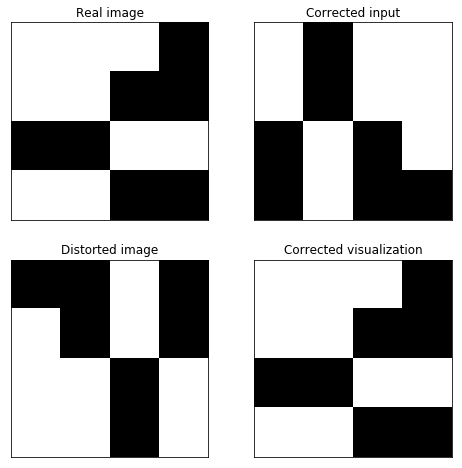

In [21]:
# Mreal = create_door_img(nbpix) 
cut = 0.5
Mreal = np.random.choice([0, 1], size=(nbpix,nbpix), p=[ 1-cut, cut])
# Mreal_split = split_matrix(Mreal)

# Predict the mangled image based on the real one
Mmang_ml = perform_prediction(Mreal,model_mangler ) # predict_mangler(Mreal)
# Predict the corrected input based on the real image
Mcor_ml = perform_prediction(Mreal, model_corrector)# predict_corrector(Mreal)
# Prediction of the output from the corrected input
Mout_ml = perform_prediction(np.round(Mcor_ml), model_mangler)
# plot the results
# vis_matrices(Mreal, Mmang_ml,Mcor_ml, Mout_ml)
if transform_type is "translation":
    vis_matrices(Mreal, Mmang_ml,Mcor_ml, translate2left(Mcor_ml))
elif transform_type is "rotation":
    vis_matrices(Mreal, Mmang_ml,Mcor_ml, rot90ccw(Mcor_ml))


In [27]:
# vis_matrices(Mreal, rot90ccw(Mreal),rot90cw(Mreal), rot90ccw(rot90cw(Mreal)))

from flask import jsonify
import json

import numpy as np
import codecs, json 

a = np.arange(10).reshape(2,5) # a 2 by 5 array
b = a.tolist() # nested lists with same data, indices
file_path = "/path.json" ## your path variable
json.dump(b, codecs.open(file_path, 'w', encoding='utf-8'), separators=(',', ':'), sort_keys=True, indent=4) ### this saves the array in .json format

In [30]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

a = np.array([[1, 2, 3], [4, 5, 6]])
print(a.shape)

# json_dump = json.dumps({'a': a, 'aa': [2, (2, 3, 4), a], 'bb': [2]}, cls=NumpyEncoder)
json_dump = json.dumps({"mat": Mreal}, cls=NumpyEncoder)
print(json_dump)

(2, 3)
{"mat": [[0, 0, 0, 1], [0, 0, 1, 1], [1, 1, 0, 0], [0, 0, 1, 1]]}


In [49]:
cut = 0.5
print(nbpix)
rmd_img = np.random.choice([0, 1], size=(nbpix,nbpix), p=[ 1-cut, cut])
print(np.random.choice([0, 1], size=(nbpix,nbpix), p=[ 1-cut, cut]))
json_dump = json.dumps({"a": rmd_img} , cls=NumpyEncoder)
print(json_dump)

4
[[0 0 0 0]
 [1 0 0 0]
 [1 1 1 0]
 [1 1 1 0]]
{"a": [[1, 0, 0, 1], [0, 1, 0, 1], [1, 0, 1, 1], [1, 1, 0, 1]]}


In [50]:
import pandas as pd
pd.Series(json_dump).to_json(orient='values')

'["{\\"a\\": [[1, 0, 0, 1], [0, 1, 0, 1], [1, 0, 1, 1], [1, 1, 0, 1]]}"]'

In [78]:
def arrayToList(arr):
    return [ii.item() for ii in arr.reshape((arr.size,1))]

In [75]:
# transform into a list
mat_list = [ii.item() for ii in Mreal.reshape((nbpix**2,1))]

In [77]:
arrayToList(Mreal)
# Mreal.size

[[0 0 0 1]
 [0 0 1 1]
 [1 1 0 0]
 [0 0 1 1]]
16


[0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1]

In [63]:
jsonify(mat_list)

RuntimeError: Working outside of application context.

This typically means that you attempted to use functionality that needed
to interface with the current application object in some way. To solve
this, set up an application context with app.app_context().  See the
documentation for more information.